# Statystyka stosowana - Raport 2  
**Emil Olszewski**

## Testowanie hipotez statystycznych

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import pandas as pd 
from matplotlib import style
from scipy.optimize import curve_fit

In [17]:
plt.style.use("seaborn-v0_8-notebook")

In [3]:
"""
    Funkcja zwracająca dane ze strony www.
"""
def load_data(path: str):

    df: pd.DataFrame = pd.read_csv(path, header=None)
    return np.array(df[0])
    

In [4]:
"""
    Funkcja tworząca wykres zbiorów krytycznych danego testu
"""
def plot_test(
        test_stat,          # statystyka testowa
        lower_bound=None,   # dolna wartość krytyczna
        upper_bound=None,   # górna wartość krytyczna
        dist=st.norm        # rozkład z jakiego pochodzi statystyka
):
    
    
    lo, hi = dist.ppf(0.001), dist.ppf(0.999)  # Zakres osi X
    xs = np.arange(lo, hi, 0.1)
    ys = dist.pdf(xs)
    p = plt.plot(xs, ys, label="Gęstość N(0, 1)" if dist == st.norm else "Gęstość Chi^2(999)")

    if lower_bound:
        plt.plot(
            [lower_bound, lower_bound],
            [0, dist.pdf(lower_bound)],
            c="red"
        )
        plt.fill_between(
            np.arange(lo, lower_bound + 0.1, 0.1),
            0,
            dist.pdf(np.arange(lo, lower_bound + 0.1, 0.1)),
            facecolor="red", 
            label="Zbiór krytyczny"
        )

    if upper_bound:
        plt.plot(
            [upper_bound, upper_bound],
            [0, dist.pdf(upper_bound)],
            c="red"
        )
        plt.fill_between(
            np.arange(upper_bound, hi, 0.1),
            0,
            dist.pdf(np.arange(upper_bound, hi, 0.1)),
            facecolor="red",
            label=None if lower_bound else "Zbiór krytyczny"
        )
        
    if lo <= test_stat <= hi:
        plt.plot(
            [test_stat, test_stat],
            [0, dist.pdf(test_stat)],
            c="orange",
            label="Statystyka testowa"
        )
    
    plt.grid(True)
    plt.legend()
    plt.xlim(lo, hi)

    return p

### Zadanie 1

In [5]:
"""
Test statystyczny dla średniej.
Zwraca:
    p-wartość,
    wynik testu,
    wartości krytyczne,
    statystykę testową
"""
def test_for_mean(
        mean,                    # wartość oczekiwana rozkładu przy założeniu hipotezy zerowej
        std,                     # odchylenie standardowe rozkładu (znane)
        alfa,                    # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):

    # Statystyka testowa, posiadająca rozkład N(0, 1) przy założeniu prawdziwości H0
    z = (np.mean(sample) - mean) * np.sqrt(len(sample)) / std
    dist = st.norm

    if alternative == "not_equal":
        lower_bound = dist.ppf(alfa/2)
        upper_bound = -lower_bound          # Ze względu na symetryczność rozkładu N(0, 1) kwantyl rzędu a/2 to -1 * kwantyl rzędu 1 - a/2
    elif alternative == "less":
        lower_bound = dist.ppf(alfa)
        upper_bound = None
    elif alternative == "greater":
        lower_bound = None
        upper_bound = dist.ppf(1 - alfa)
    else:
        raise Exception("Podano nieprawidłową hipotezę alternatywną")


    # p-wartość 

    # p-wartość to taka wartość poziomu istotności testu statystycznego, że
    # statystyka testowa równa się wartości krytycznej testu.

    if alternative == "not_equal": 
        if z >= 0:
            pvalue = 2 * (1 - dist.cdf(z))
        else:
            pvalue = 2 * dist.cdf(z)
    elif alternative == "less":
        pvalue = dist.cdf(z)
    else:
        pvalue = 1 - dist.cdf(z)

    # Wynik testu (True - przyjęcie hipotezy zerowej, False - odrucenie)
    result = z < upper_bound if not lower_bound else (
        z > lower_bound if not upper_bound else lower_bound < z < upper_bound
    )

    return (pvalue, result, (lower_bound, upper_bound), z)

In [11]:
"""
Wykres testu dla średniej.
"""
def plot_mean_test(
        mean,                    # wartość oczekiwana rozkładu przy założeniu hipotezy zerowej
        std,                     # odchylenie standardowe rozkładu (znane)
        alfa,                    # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):

    pvalue, result, (lower_bound, upper_bound), z = test_for_mean(mean, std, alfa, sample, alternative)

    alt_hypo = "mu != 1.5" if alternative == "not_equal" else (
               "mu < 1.5" if alternative == "less" else "mu > 1.5"
    )

    print(f"p-wartość (dla H1: {alt_hypo}): {pvalue}")
    print(f"Przyjęto hipotezę zerową: {'Tak' if result else 'Nie'}")

    plt.show(plot_test(z, lower_bound, upper_bound, st.norm))

In [7]:
data1 = load_data("http://prac.im.pwr.edu.pl/~wyloman/ss_2022_2023/lista8_zad1.txt")

p-wartość (dla H1: mu != 1.5): 1.902482582482688e-12
Przyjęto hipotezę zerową: Nie


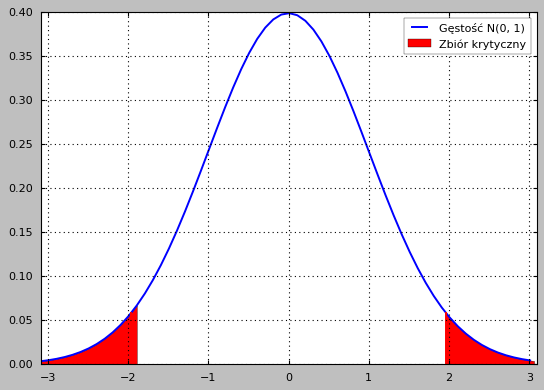

In [18]:
plot_mean_test(1.5, 0.2, 0.05, data1, "not_equal")

p-wartość (dla H1: mu != 1.5): 1.902482582482688e-12
Przyjęto hipotezę zerową: Nie


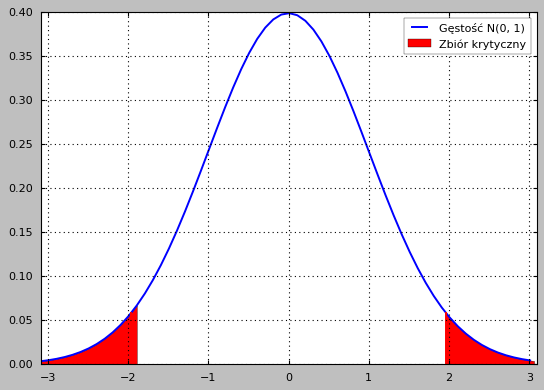

In [19]:
plot_mean_test(1.5, 0.2, 0.05, data1, "not_equal")

p-wartość (dla H1: mu != 1.5): 1.902482582482688e-12
Przyjęto hipotezę zerową: Nie


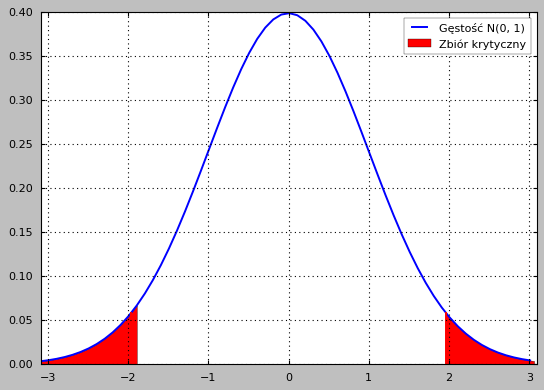

In [20]:
plot_mean_test(1.5, 0.2, 0.05, data1, "not_equal")

### Zadanie 2

In [21]:
"""
Test statystyczny dla wariancji.
Zwraca:
    p-wartość,
    wynik testu,
    wartości krytyczne,
    statystykę testową 
"""
def test_for_var(
        var,                     # wariancja rozkładu przy założeniu hipotezy zerowej
        alfa,                    # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):
    
    # Statystyka testowa (rozkład Chi^2)
    x2 = (len(sample) - 1) * np.var(sample) / var
    dist = st.chi2(len(sample) - 1)

    
    # Wartości krytyczne 

    if alternative == "not_equal":
        lower_bound = dist.ppf(alfa/2)
        upper_bound = dist.ppf(1 - alfa/2)         
    elif alternative == "less":
        lower_bound = dist.ppf(alfa)
        upper_bound = None
    elif alternative == "greater":
        lower_bound = None
        upper_bound = dist.ppf(1 - alfa)
    else:
        raise Exception("Podano nieprawidłową hipotezę alternatywną")    
    
    
    # p-wartość

    if alternative == "not_equal":
        if x2 >= (len(sample) - 1):
            pvalue = 2 * (1 - dist.cdf(x2))
        else:
            pvalue = 2 * dist.cdf(x2)
    elif alternative == "less":
        pvalue = dist.cdf(x2)
    else:
        pvalue = 1 - dist.cdf(x2)

    result = x2 < upper_bound if not lower_bound else (x2 > lower_bound if not upper_bound else lower_bound < x2 < upper_bound)

    return (pvalue, result, (lower_bound, upper_bound), x2)
    

In [25]:
"""
Wykres zbioru krytycznego dla wariancji
"""
def plot_var_test(
        var,                     # wariancja rozkładu przy założeniu hipotezy zerowej
        alfa,                    # poziom istotności testu
        sample,                  # testowana próbka
        alternative="not_equal"  # hipoteza alterantywna
):
        
    pvalue, result, (lower_bound, upper_bound), x2 = test_for_var(var, alfa, sample, alternative)

    alt_hypo = "sigma^2 != 1.5" if alternative == "not_equal" else (
               "sigma^2 < 1.5" if alternative == "less" else "sigma^2 > 1.5"
    )

    print(f"p-wartość (dla H1: {alt_hypo}): {pvalue}")
    print(f"Przyjęto hipotezę zerową: {'Tak' if result else 'Nie'}")

    plt.show(plot_test(x2, lower_bound, upper_bound, st.chi2(len(sample) - 1)))
    
    

In [23]:
data2 = load_data("http://prac.im.pwr.edu.pl/~wyloman/ss_2022_2023/lista8_zad2.txt")

p-wartość (dla H1: sigma^2 != 1.5): 0.016011673877854404
Przyjęto hipotezę zerową: Nie


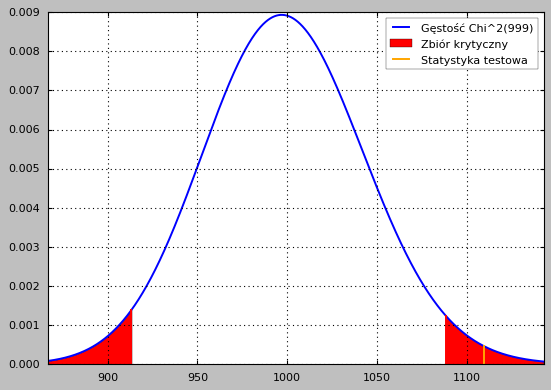

In [26]:
plot_var_test(1.5, 0.05, data2, alternative="not_equal")

p-wartość (dla H1: sigma^2 < 1.5): 0.9919941630610728
Przyjęto hipotezę zerową: Tak


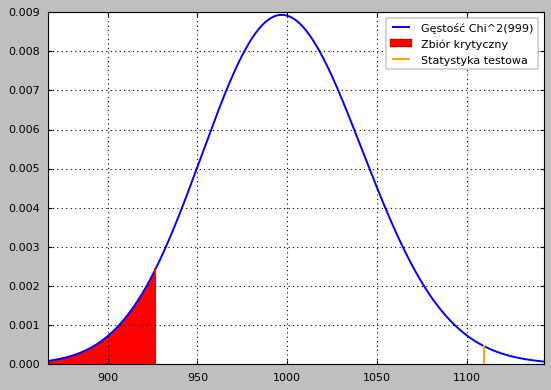

In [27]:
plot_var_test(1.5, 0.05, data2, alternative="less")

p-wartość (dla H1: sigma^2 > 1.5): 0.008005836938927202
Przyjęto hipotezę zerową: Nie


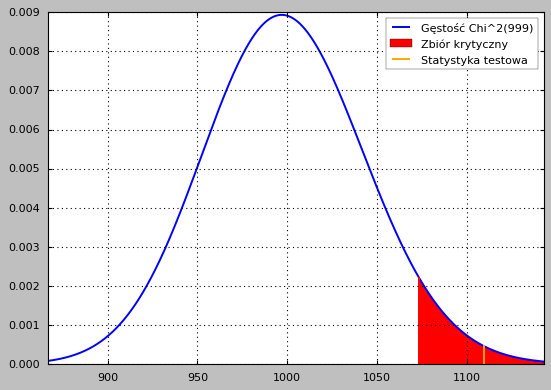

In [28]:
plot_var_test(1.5, 0.05, data2, alternative="greater")

Zwiększanie poziomu istotności testu statystycznego prowadzi do zwiększenia się powierzchni zbioru krytycznego, a co za tym idzie do **zwiększenia się prawdopodobieństwa popełnienia błędu I rodzaju**. Gdy poziom istotności przekroczy p-wartość dojdzie też do zmianu wyniku testu (odrzucenia hipotezy zerowej na korzyść alternatywnej). Jednakże skutkuje to też większym prawdopodobieństwem odrzucenia hipotezy zerowej gdy jest ona fałszywa, to jest **zwiększeniem mocy testu**. 

Analogicznie, gdy będziemy zmniejszać poziom istotności, razem z nim będzie **maleć** prawdopodobieństwo popełnienia **błędu I rodzaju** jak i **moc testu**.

### Zadanie 3

#### Błąd I rodzaju

In [44]:
"""
Model liniowy do dopasowywania do danych
"""
def linear(x, a, b):
    return a * x + b

In [32]:
def type_one_err(
        mean,                    # średnia rozkładu
        std,                     # wariancja rozkładu 
        alfa,                    # poziom istotności testu
        test_func,               # użyty test
        alternative="not_equal", # hipoteza alterantywna
        num_of_runs=1000         # ilość przetestowanych próbek
):
    
    tests_failed = num_of_runs

    for _ in range(num_of_runs):

        sample = np.random.normal(mean, std, num_of_runs)
        tests_failed -= test_func(mean, std, alfa, sample, alternative)[1]

    return tests_failed / num_of_runs



In [33]:
type_one_err(0, 1, 0.05, test_for_mean)

0.052

In [48]:
def plot_type_one_errs(
        mean,                    # średnia rozkładu
        std,                     # wariancja rozkładu 
        alfas,                   # zakres poziomu istotności
        test_func,               # użyty test
        alternative="not_equal", # hipoteza alterantywna
        num_of_runs=1000         # ilość przetestowanych próbek dla każdego poziomu istotności

):
    
    errs = np.array([type_one_err(mean, std, alfa, test_func, alternative, num_of_runs) for alfa in alfas])
    
    popt, _ = curve_fit(linear, alfas, errs)


    plt.plot(alfas, alfas, label="Poziom ufności")
    plt.scatter(alfas, errs, label="Błędy I rodzaju", c="green")
    plt.plot(alfas, popt[0] * alfas + popt[1], label="Dopasowany model liniowy", c="red")
    plt.legend(loc="upper left")
    plt.grid()

    plt.show()

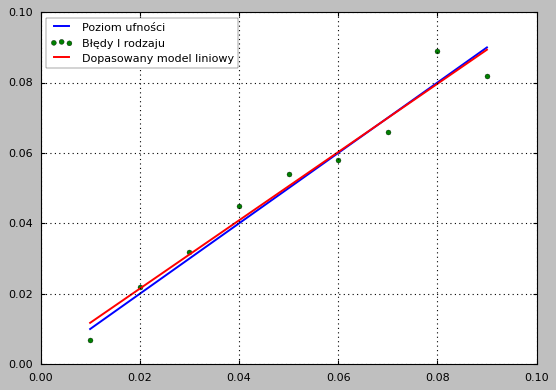

In [49]:
plot_type_one_errs(0, 1, np.arange(0.01, 0.1, 0.01), test_for_mean)